In [1]:
import string, re, os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
import jieba
import operator
import zhconv
from collections import Counter
import warnings
warnings.filterwarnings(action='ignore', category=UserWarning, module='gensim')

from gensim.models import Word2Vec

from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation
from tensorflow.keras.layers import Bidirectional, GlobalMaxPool1D
from tensorflow.keras.models import Model

In [2]:
model_path = r'../models/zhwiki.50d.word2vec'

In [3]:
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif'] = ['SimHei']  #用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False  #用来正常显示负号

# 影评数据
豆瓣的电影短评论

In [4]:
# 文件路径
data_path = "../datasets/"
comments = ['douban_movie_comments.csv', 'douban_movie_short_comments.csv']

In [5]:
df1 = pd.read_csv(os.path.join(data_path, comments[0]), low_memory=False)
print(df1.info())
df1.head(5)

# 目标数据 comment，star 的非空数量不同，数据类型都为 object

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 261497 entries, 0 to 261496
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   id       261497 non-null  object
 1   link     261497 non-null  object
 2   name     261497 non-null  object
 3   comment  261495 non-null  object
 4   star     261497 non-null  object
dtypes: object(5)
memory usage: 10.0+ MB
None


,id,link,name,comment,star
0,1,https://movie.douban.com/subject/26363254/,战狼2,吴京意淫到了脑残的地步，看了恶心想吐,1
1,2,https://movie.douban.com/subject/26363254/,战狼2,首映礼看的。太恐怖了这个电影，不讲道理的，完全就是吴京在实现他这个小粉红的英雄梦。各种装备轮...,2
2,3,https://movie.douban.com/subject/26363254/,战狼2,吴京的炒作水平不输冯小刚，但小刚至少不会用主旋律来炒作…吴京让人看了不舒服，为了主旋律而主旋...,2
3,4,https://movie.douban.com/subject/26363254/,战狼2,凭良心说，好看到不像《战狼1》的续集，完虐《湄公河行动》。,4
4,5,https://movie.douban.com/subject/26363254/,战狼2,中二得很,1


In [6]:
df2 = pd.read_csv(os.path.join(data_path, comments[1]), low_memory=False)
print(df2.info())
df2.head(5)

# 目标数据 Comment， Star

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2125056 entries, 0 to 2125055
Data columns (total 10 columns):
 #   Column         Dtype 
---  ------         ----- 
 0   ID             int64 
 1   Movie_Name_EN  object
 2   Movie_Name_CN  object
 3   Crawl_Date     object
 4   Number         int64 
 5   Username       object
 6   Date           object
 7   Star           int64 
 8   Comment        object
 9   Like           int64 
dtypes: int64(4), object(6)
memory usage: 162.1+ MB
None


,ID,Movie_Name_EN,Movie_Name_CN,Crawl_Date,Number,Username,Date,Star,Comment,Like
0,0,Avengers Age of Ultron,复仇者联盟2,2017-01-22,1,然潘,2015-05-13,3,连奥创都知道整容要去韩国。,2404
1,1,Avengers Age of Ultron,复仇者联盟2,2017-01-22,2,更深的白色,2015-04-24,2,非常失望，剧本完全敷衍了事，主线剧情没突破大家可以理解，可所有的人物都缺乏动机，正邪之间、...,1231
2,2,Avengers Age of Ultron,复仇者联盟2,2017-01-22,3,有意识的贱民,2015-04-26,2,2015年度最失望作品。以为面面俱到，实则画蛇添足；以为主题深刻，实则老调重弹；以为推陈出...,1052
3,3,Avengers Age of Ultron,复仇者联盟2,2017-01-22,4,不老的李大爷耶,2015-04-23,4,《铁人2》中勾引钢铁侠，《妇联1》中勾引鹰眼，《美队2》中勾引美国队长，在《妇联2》中终于...,1045
4,4,Avengers Age of Ultron,复仇者联盟2,2017-01-22,5,ZephyrO,2015-04-22,2,虽然从头打到尾，但是真的很无聊啊。,723


In [7]:
df2.rename(columns={"Comment": "comment", "Star": "star"}, inplace=True)
df2.head(2)

# 目标数据列 命名一致

,ID,Movie_Name_EN,Movie_Name_CN,Crawl_Date,Number,Username,Date,star,comment,Like
0,0,Avengers Age of Ultron,复仇者联盟2,2017-01-22,1,然潘,2015-05-13,3,连奥创都知道整容要去韩国。,2404
1,1,Avengers Age of Ultron,复仇者联盟2,2017-01-22,2,更深的白色,2015-04-24,2,非常失望，剧本完全敷衍了事，主线剧情没突破大家可以理解，可所有的人物都缺乏动机，正邪之间、...,1231


In [8]:
# 提取目标数据，评论和评分

dataset = df1[['comment', 'star']].append(df2[['comment', 'star']],
                                          ignore_index=True)
dataset.info()
dataset.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2386553 entries, 0 to 2386552
Data columns (total 2 columns):
 #   Column   Dtype 
---  ------   ----- 
 0   comment  object
 1   star     object
dtypes: object(2)
memory usage: 36.4+ MB


,comment,star
0,吴京意淫到了脑残的地步，看了恶心想吐,1
1,首映礼看的。太恐怖了这个电影，不讲道理的，完全就是吴京在实现他这个小粉红的英雄梦。各种装备轮...,2
2,吴京的炒作水平不输冯小刚，但小刚至少不会用主旋律来炒作…吴京让人看了不舒服，为了主旋律而主旋...,2
3,凭良心说，好看到不像《战狼1》的续集，完虐《湄公河行动》。,4
4,中二得很,1
5,“犯我中华者，虽远必诛”，吴京比这句话还要意淫一百倍。,1
6,脑子是个好东西，希望编剧们都能有。,2
7,三星半，实打实的7分。第一集在爱国主旋律内部做着各种置换与较劲，但第二集才真正显露吴京的野心...,4
8,开篇长镜头惊险大气引人入胜 结合了水平不俗的快剪下实打实的真刀真枪 让人不禁热血沸腾 特别弹...,4
9,15/100吴京的冷峰在这部里即像成龙，又像杰森斯坦森，但体制外的同类型电影，主角总是代表个...,1


## 数据清洗

In [9]:
# 删除评论为空的行
dataset = dataset.dropna()

# 删除评分不为数值的行
dataset = dataset[dataset['star'].isin(list('12345') + list(range(1, 6)))]

# 格式转换
dataset['star'] = dataset['star'].astype('int')
dataset['comment'] = dataset['comment'].astype('str')

print(dataset.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2386550 entries, 0 to 2386552
Data columns (total 2 columns):
 #   Column   Dtype 
---  ------   ----- 
 0   comment  object
 1   star     int64 
dtypes: int64(1), object(1)
memory usage: 54.6+ MB
None


## 数据类别不均匀
> **如何处理这种不平衡?**

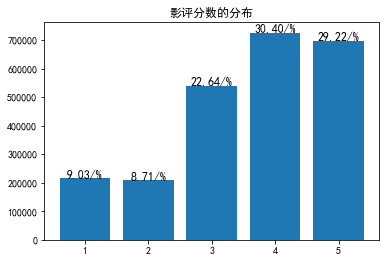

In [59]:
x = np.arange(1, 6)
nums = [len(dataset[dataset['star'] == i]) for i in x]


def plot_score_distribution(x, nums, gap=1000):
    plt.bar(x, nums)

    plt.title('影评分数的分布')
    for x, y in zip(x, nums):
        plt.text(x,
                 y + gap,
                 f"{(y / sum(nums))*100:.2f}/%",
                 ha='center',
                 fontsize=12)
    plt.show()


plot_score_distribution(x, nums)

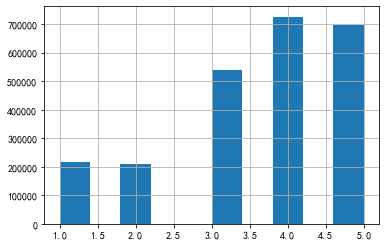

In [16]:
dataset['star'].hist()

## 文本预处理
- 删除符号
- 繁体转简体
- 分词后以空格连接
- 英文大写转小写

In [18]:
punct = r"，。！？、；：“”\n＂＃＄％＆＇（）＊＋－／＜＝＞＠［＼］＾＿｀｛｜｝～｟｠｢｣､〃《》「」『』【】〔〕〖〗〘〙〚〛〜〝〟〰〾〿–—‛„‟…‧﹏★☆•→▽"


def clean_special_chars(text):
    re_tok = re.compile(f'([{string.punctuation}{punct}])')
    return re_tok.sub(r' ', text)


def simplify(text):
    return zhconv.convert(text, 'zh-cn')


def cut_join(text):
    space = ' '
    words = jieba.cut(text)
    return space.join([w.lower() for w in words if not w.isspace()])


def preprocess(text):
    text = clean_special_chars(text)
    text = simplify(text)
    text = cut_join(text)
    return text


dataset['cleaned_comment'] = dataset['comment'].apply(preprocess)

dataset['cleaned_comment'].head(10)

Building prefix dict from the default dictionary ...
Dumping model to file cache /tmp/jieba.cache
Loading model cost 0.411 seconds.
Prefix dict has been built successfully.


0                         吴京 意淫 到 了 脑残 的 地步 看 了 恶心 想 吐
1    首映礼 看 的 太 恐怖 了 这个 电影 不讲道理 的 完全 就是 吴京 在 实现 他 这个...
2    吴京 的 炒作 水平 不输 冯小刚 但小刚 至少 不会 用 主旋律 来 炒作 吴京 让 人 ...
3                     凭良心说 好 看到 不像 战狼 1 的 续集 完虐 湄公河 行动
4                                                中二得 很
5                   犯 我 中华 者 虽远必 诛 吴京 比 这句 话 还要 意淫 一百倍
6                            脑子 是 个 好 东西 希望 编剧 们 都 能 有
7    三星 半 实打实 的 7 分 第一集 在 爱国 主旋律 内部 做 着 各种 置换 与 较劲 ...
8    开篇 长镜头 惊险 大气 引人入胜 结合 了 水平 不俗 的 快 剪下 实打实 的 真刀真枪...
9    15 100 吴京 的 冷峰 在 这部 里 即 像 成龙 又 像杰 森斯坦 森 但 体制 外...
Name: cleaned_comment, dtype: object

In [32]:
# # 保存处理好的数据
# with open('../datasets/douban_comments.txt', 'w') as f:
#     for comment in dataset['cleaned_comment']:
#         f.write(comment + '\n')

# with open('../datasets/douban_comment_stars.txt', 'w') as f:
#     for star in dataset['star']:
#         f.write(comment + '\n')

### 查看影评的字数分布
> **如何更好的处理不同影评的这种字数差别？**

In [35]:
dataset['comment_length'] = dataset['comment'].apply(len).astype('int')

min_ = dataset['comment_length'].min()
max_ = dataset['comment_length'].max()
median = dataset['comment_length'].median()
mean = dataset['comment_length'].mean()
mode = dataset['comment_length'].mode()[0]
print(
    f"min length:{min_}, max length:{max_}, median length:{median}, mean length:{mean}, mode length:{mode}"
)

min length:1, max length:4247, median length:23.0, mean length:37.4620741237351, mode length:10


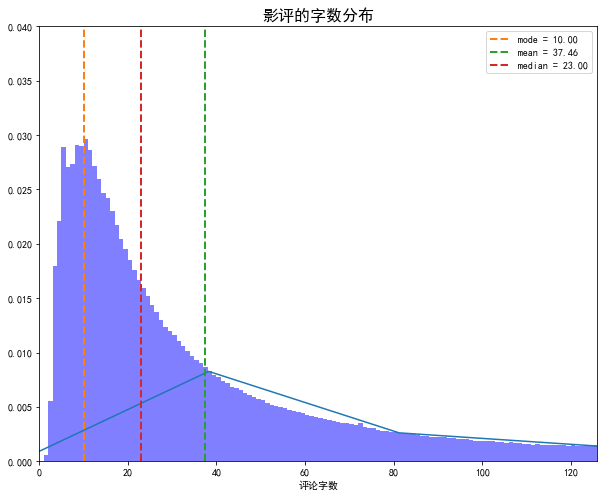

In [36]:
fig, ax = plt.subplots(figsize=(10, 8))
sn.distplot(dataset['comment_length'],
            bins=dataset['comment_length'].max(),
            hist_kws={
                "alpha": 0.5,
                "color": "blue"
            },
            ax=ax)
ax.set_xlim(left=0, right=np.percentile(dataset['comment_length'], 95))
ax.set_xlabel('评论字数')
ymax = 0.04
plt.ylim(0, ymax)
ax.plot([mode, mode], [0, ymax], '--', label=f'mode = {mode:.2f}', linewidth=2)
ax.plot([mean, mean], [0, ymax], '--', label=f'mean = {mean:.2f}', linewidth=2)
ax.plot([median, median], [0, ymax],
        '--',
        label=f'median = {median:.2f}',
        linewidth=2)
ax.set_title('影评的字数分布', fontsize=16)
plt.legend()
plt.show()

In [37]:
# 字数少于 5 的评论占了 5%
np.percentile(dataset['comment_length'], 5)

5.0

In [40]:
# 一个字的评论
dataset[dataset['comment_length'] == 1].head(10)

,comment,star,cleaned_comment,comment_length
191,赞,5,赞,1
198,赞,5,赞,1
247,好,5,好,1
752,屎,1,屎,1
2135,哎,3,哎,1
2140,哎,3,哎,1
2760,牛,5,牛,1
3420,x,4,x,1
4352,烂,1,烂,1
4605,爽,5,爽,1


In [41]:
# 两个字的评论
dataset[dataset['comment_length'] == 2][['comment', 'star']].head(10)

,comment,star
204,温馨,5
216,温馨,5
525,幼齿,1
565,疯了,5
606,疯了,5
642,战狗,1
648,战狗,1
681,……,1
788,傻逼,1
1261,性感,5


In [42]:
# 三个字的评论
dataset[dataset['comment_length'] == 3][['comment', 'star']].head(10)

,comment,star
110,没看过,1
136,にまび,1
174,超感动,5
176,超感动,5
206,好看！,5
210,励志。,4
218,好看！,5
222,励志。,4
234,煽情。,3
242,煽情。,3


In [44]:
# 四个字的评论
dataset[dataset['comment_length'] == 4][['cleaned_comment', 'star']].head(10)

,cleaned_comment,star
4,中二得 很,1
67,3d 扣分,2
141,爱 与 坚持,3
162,勇敢 面对,4
180,励志 大片,5
208,mit,4
220,mit,4
251,平民 励志,4
258,平民 励志,4
265,苦尽甘来,4


/home/yangbin7/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until


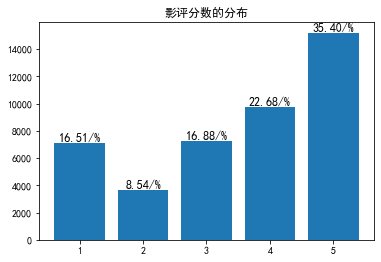

In [48]:
# 四字评论对应的分数分布
x = np.arange(1, 6)
nums = [
    len(dataset[dataset['comment_length'] == 3][dataset['star'] == i])
    for i in x
]
plot_score_distribution(x, nums)

> 5% 的影评字数少于 3 个，删除这些数据；删除后对类别分布无影响


In [ ]:
# 删除字数少于 3 的评论
dataset = dataset[dataset['comment_length'] > 3]
print(dataset.info())

### 影评的词数分布
> 已经分词处理过文本，基本单位变成单词

In [54]:
def get_words_num(s):
    words = s.strip().split()
    return len(words)


dataset['words_num'] = dataset['cleaned_comment'].apply(get_words_num).astype(
    'int')

min_ = dataset['words_num'].min()
max_ = dataset['words_num'].max()
median = dataset['words_num'].median()
mean = dataset['words_num'].mean()
mode = dataset['words_num'].mode()[0]
print(
    f"min num of words:{min_}, max num of words:{max_}, median num of words:{median},\nmean num of words:{mean}, mode num of words:{mode}"
)

min num of words:0, max num of words:1941, median num of words:12.0,
mean num of words:19.212695313318388, mode num of words:4


In [56]:
dataset[dataset['words_num'] == 0]

,comment,star,cleaned_comment,comment_length,words_num
681,……,1,,2,0
2242,= =,5,,3,0
2646,。。。,5,,3,0
3678,。。。。。。,2,,6,0
3757,？？,1,,2,0
...,...,...,...,...,...
2376705,……,3,,3,0
2378886,。。。。,5,,5,0
2381227,！,5,,2,0
2381900,★★★★★★★★★★★★★★,5,,15,0


/home/yangbin7/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  after removing the cwd from sys.path.


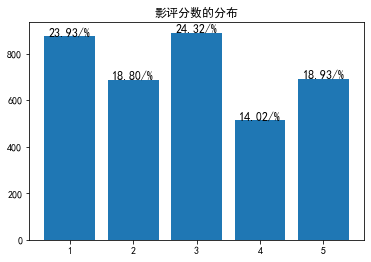

In [63]:
x = np.arange(1, 6)
zero_words = dataset[dataset['words_num'] == 0]
nums = [
    len(zero_words[dataset['words_num'] == 0][zero_words['star'] == i]) for i in x
]
plot_score_distribution(x, nums, gap=0)

> **这一部分纯标点符号的评论怎么处理?**

In [64]:
dataset = dataset[dataset['words_num'] > 0]
print(dataset.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2382890 entries, 0 to 2386552
Data columns (total 5 columns):
 #   Column           Dtype 
---  ------           ----- 
 0   comment          object
 1   star             int64 
 2   cleaned_comment  object
 3   comment_length   int64 
 4   words_num        int64 
dtypes: int64(3), object(2)
memory usage: 109.1+ MB
None


# 文本向量化

## 词向量
- 使用基于中文维基语料，和 gensim 包的训练出来的词向量

In [65]:
model = Word2Vec.load(model_path)
wv = model.wv
del model

In [66]:
len(wv.vocab)

845989

In [67]:
wv.most_similar(['吴京'])

[('张静初', 0.8863259553909302),
 ('刘烨', 0.8568055629730225),
 ('廖凡', 0.8530554175376892),
 ('张震', 0.8500816822052002),
 ('张涵予', 0.8481923341751099),
 ('胡军', 0.8465080857276917),
 ('段奕宏', 0.8462876081466675),
 ('黄轩', 0.844296932220459),
 ('黄渤', 0.8436167240142822),
 ('喻亢', 0.8426705598831177)]

In [68]:
index = wv.index2word.index('吴京')
index

48404

## 创建词汇表

In [69]:
def build_vocab(texts):
    vocab = {}
    for t in texts:
        words = t.strip().split()
        for word in words:
            if word != 'unkown':
                vocab[word] = vocab.get(word, 0) + 1
    return vocab

In [70]:
vocab = build_vocab(dataset['cleaned_comment'])

print("评论总单词数：{}；词汇表单词个数：{}".format(sum(vocab.values()), len(vocab)))

评论总单词数：45852058；词汇表单词个数：342733


In [72]:
word2index = {'unkown': 0}
for word, _ in vocab.items():
    word2index[word] = len(word2index)

word2index

{'unkown': 0,
 '吴京': 1,
 '意淫': 2,
 '到': 3,
 '了': 4,
 '脑残': 5,
 '的': 6,
 '地步': 7,
 '看': 8,
 '恶心': 9,
 '想': 10,
 '吐': 11,
 '首映礼': 12,
 '太': 13,
 '恐怖': 14,
 '这个': 15,
 '电影': 16,
 '不讲道理': 17,
 '完全': 18,
 '就是': 19,
 '在': 20,
 '实现': 21,
 '他': 22,
 '小': 23,
 '粉红': 24,
 '英雄': 25,
 '梦': 26,
 '各种': 27,
 '装备': 28,
 '轮番': 29,
 '上场': 30,
 '视': 31,
 '物理': 32,
 '逻辑': 33,
 '于': 34,
 '不顾': 35,
 '不得不': 36,
 '说': 37,
 '有钱': 38,
 '真': 39,
 '好': 40,
 '随意': 41,
 '胡闹': 42,
 '炒作': 43,
 '水平': 44,
 '不输': 45,
 '冯小刚': 46,
 '但小刚': 47,
 '至少': 48,
 '不会': 49,
 '用': 50,
 '主旋律': 51,
 '来': 52,
 '让': 53,
 '人': 54,
 '不': 55,
 '舒服': 56,
 '为了': 57,
 '而': 58,
 '煽情': 59,
 '觉得': 60,
 '是': 61,
 '个': 62,
 '大': 63,
 '做作': 64,
 '谎言': 65,
 '家': 66,
 '7': 67,
 '29': 68,
 '更新': 69,
 '片子': 70,
 '整体': 71,
 '不如': 72,
 '湄公河': 73,
 '行动': 74,
 '1': 75,
 '不够': 76,
 '流畅': 77,
 '编剧': 78,
 '有毒': 79,
 '台词': 80,
 '尴尬': 81,
 '2': 82,
 '刻意': 83,
 '显得': 84,
 '如此': 85,
 '不合时宜': 86,
 '又': 87,
 '多余': 88,
 '凭良心说': 89,
 '看到': 90,
 '不像': 91,
 '战狼': 92,
 

## 评论中没有词向量中的词
- 解决措施：继续分词
> **拼写纠错??：如“鸡冻”--> “激动”**

In [73]:
def check_coverage(vocab, wv):
    known_words = {}
    unknown_words = {}
    no_known_words = 0
    no_unknown_words = 0
    for word in vocab:
        try:
            known_words[word] = wv[word]
            no_known_words += vocab[word]
        except:
            unknown_words[word] = vocab[word]
            no_unknown_words += vocab[word]
    print('词汇表中 {:.2%} 的单词有词向量'.format(len(known_words) / len(vocab)))
    print('评论的所有单词中 {:.2%} 的单词有词向量'.format(
        no_known_words / (no_known_words + no_unknown_words)))
    unknown_words = sorted(unknown_words.items(),
                           key=operator.itemgetter(1))[::-1]
    return unknown_words

In [74]:
unknown_words = check_coverage(vocab, wv)

词汇表中 46.14% 的单词有词向量
评论的所有单词中 97.08% 的单词有词向量


In [75]:
len(unknown_words)

184582

In [76]:
# 无词向量的 单词
sorted(unknown_words, key=lambda w: len(w[0]), reverse=True)[:50]

[('ahhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhotdwarvesatyourservice',
  1),
 ('blahblahblahblahblahblahblahblahblahblahblahblahblahblahblahblahblahblahblahblahblahblahblahblahblahblahblahblahblahblahblahblahblahblahblahblahblahblahblahblahblahblahblahblahblahblahblahblahblahblahblahblahblahblahblah',
  1),
 ('hiusjufbjijhjjsfightdjsiosnwnbombsisjwnexplosionwhshbdbwwhatfuckjusthappenddhsjsndhdjfighrekizjekilldbiejsshotdhsjsnthatbitchsjdjjffuckjejsh',
  1),
 ('111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111',
  1),
 ('100000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000',
  1),
 ('teateatatteateatatteateatatteateatatteateatatteateatatteateatatteateata

In [80]:
# 出现次数最多的无词向量单词
sorted(unknown_words, key=lambda w: w[1], reverse=True)[:50]

[('5', 36985),
 ('3', 36146),
 ('2', 34218),
 ('1', 32594),
 ('3d', 30606),
 ('4', 23395),
 ('美队', 14923),
 ('7', 14083),
 ('8', 13582),
 ('😂', 10231),
 ('10', 9704),
 ('星给', 9400),
 ('6', 9342),
 ('9', 7269),
 ('0', 7264),
 ('一般般', 6970),
 ('12', 6880),
 ('尿点', 6691),
 ('2016', 6165),
 ('加一星', 5719),
 ('⋯', 4829),
 ('20', 4604),
 ('残粉', 4342),
 ('😭', 3975),
 ('打一星', 3876),
 ('90', 3689),
 ('脑残粉', 3674),
 ('2015', 3547),
 ('老谋子', 3527),
 ('80', 3506),
 ('30', 3449),
 ('复联', 3245),
 ('泪目', 3243),
 ('100', 3125),
 ('刚看', 2987),
 ('无尿点', 2902),
 ('️', 2796),
 ('诚哥', 2781),
 ('👍', 2759),
 ('￣', 2703),
 ('讲真', 2703),
 ('╯', 2568),
 ('15', 2566),
 ('❤', 2428),
 ('搞笑片', 2397),
 ('逼格', 2361),
 ('╰', 2334),
 ('太赞', 2329),
 ('╭', 2196),
 ('╮', 2169)]

In [81]:
'2' in wv

False

### 没有词向量的汉语短语

In [82]:
def is_chinese(str):
    for s in str:
        if u'\u4e00' <= s <= u'\u9fff':
            return True
    return False

In [83]:
is_chinese('君子之交淡如水')

True

In [84]:
unknown_chinese = [(w, c) for w, c in unknown_words if is_chinese(w)]
len(unknown_chinese)

167519

In [85]:
sorted(unknown_chinese, key=lambda w: len(w[0]), reverse=True)[:10]

[('蛤蛤蛤蛤蛤蛤蛤蛤蛤蛤蛤蛤蛤蛤蛤蛤蛤蛤蛤蛤蛤蛤蛤蛤蛤蛤蛤蛤蛤蛤蛤蛤蛤蛤蛤蛤蛤蛤蛤蛤蛤蛤蛤蛤蛤蛤蛤蛤蛤蛤蛤蛤蛤蛤蛤蛤蛤蛤蛤蛤蛤蛤蛤蛤蛤蛤蛤蛤蛤蛤蛤蛤蛤蛤蛤蛤蛤蛤蛤蛤蛤蛤蛤蛤蛤蛤蛤',
  1),
 ('尼尼尼尼尼尼尼尼尼尼尼尼', 1),
 ('求范范范范范范范范范范爷', 1),
 ('丈二和尚摸不着头脑', 8),
 ('冰冻三尺非一日之寒', 1),
 ('九百六十万平方公里', 1),
 ('八仙过海各显神通', 37),
 ('巧妇难为无米之炊', 5),
 ('百尺竿头更进一步', 5),
 ('燕雀安知鸿鹄之志', 3)]

In [86]:
sorted(unknown_chinese, key=lambda w: w[1], reverse=True)[:10]

[('美队', 14923),
 ('星给', 9400),
 ('一般般', 6970),
 ('尿点', 6691),
 ('加一星', 5719),
 ('残粉', 4342),
 ('打一星', 3876),
 ('脑残粉', 3674),
 ('老谋子', 3527),
 ('复联', 3245)]

> **没有词向量的汉语短语，前向最大匹配继续分词**

In [109]:
def cut(s):
    words = []
    n = len(s)
    start = 0
    while start < n:
        end = n
        while start <= end <= n:
            word = s[start:end]
            if word in wv:
                if not words or word != words[-1]:
                    words.append(word)
                start = end
                break
            else:
                end -= 1
        if start < end:
            words.append('unknown')
            start += 1
    return words

In [111]:
for w, _ in sorted(unknown_chinese, key=lambda w: len(w[0]),
                   reverse=True)[:10]:
    print(w + ':', cut(w))

蛤蛤蛤蛤蛤蛤蛤蛤蛤蛤蛤蛤蛤蛤蛤蛤蛤蛤蛤蛤蛤蛤蛤蛤蛤蛤蛤蛤蛤蛤蛤蛤蛤蛤蛤蛤蛤蛤蛤蛤蛤蛤蛤蛤蛤蛤蛤蛤蛤蛤蛤蛤蛤蛤蛤蛤蛤蛤蛤蛤蛤蛤蛤蛤蛤蛤蛤蛤蛤蛤蛤蛤蛤蛤蛤蛤蛤蛤蛤蛤蛤蛤蛤蛤蛤蛤蛤: ['蛤']
尼尼尼尼尼尼尼尼尼尼尼尼: ['尼尼']
求范范范范范范范范范范爷: ['求', '范范', '爷']
丈二和尚摸不着头脑: ['丈二', '和尚', '摸不着头脑']
冰冻三尺非一日之寒: ['冰冻', '三尺', '非一', '日', '之寒']
九百六十万平方公里: ['九百', '六十万', '平方公里']
八仙过海各显神通: ['八仙过海', '各显神通']
巧妇难为无米之炊: ['巧妇', '难为', '无米', '之', '炊']
百尺竿头更进一步: ['百尺竿头', '更进一步']
燕雀安知鸿鹄之志: ['燕雀', '安知', '鸿鹄', '之志']


In [112]:
for w, _ in sorted(unknown_chinese, key=lambda w: w[1], reverse=True)[:10]:
    print(w + ':', cut(w))

美队: ['美', '队']
星给: ['星', '给']
一般般: ['一般', '般']
尿点: ['尿', '点']
加一星: ['加一', '星']
残粉: ['残', '粉']
打一星: ['打一', '星']
脑残粉: ['脑残', '粉']
老谋子: ['老', '谋', '子']
复联: ['复', '联']


### 全英文字符短语

In [113]:
def is_string(str):
    for s in str:
        if s not in string.ascii_lowercase:
            return False
    return True

In [114]:
unknown_string = [(w, c) for w, c in unknown_words if is_string(w)]
len(unknown_string)

7777

In [115]:
unknown_string

[('wyf', 237),
 ('qwq', 206),
 ('rdj', 145),
 ('tfboy', 140),
 ('shirly', 131),
 ('hhhhh', 127),
 ('mdzz', 127),
 ('exm', 119),
 ('xddd', 97),
 ('happyending', 88),
 ('xmen', 87),
 ('puny', 82),
 ('balabala', 78),
 ('biubiubiu', 76),
 ('blabla', 75),
 ('dvdrip', 73),
 ('hhhhhh', 65),
 ('antman', 64),
 ('anglebaby', 64),
 ('teamcap', 63),
 ('everthing', 62),
 ('quq', 61),
 ('qvq', 56),
 ('duangduangduang', 55),
 ('ccav', 52),
 ('mitsuha', 49),
 ('mlgb', 49),
 ('sherly', 48),
 ('blablabla', 48),
 ('prpr', 48),
 ('spiderboy', 45),
 ('hhhhhhh', 45),
 ('hodor', 44),
 ('duangduang', 44),
 ('himym', 43),
 ('shirely', 41),
 ('prprpr', 41),
 ('teamironman', 40),
 ('stucky', 40),
 ('blingbling', 39),
 ('nnd', 39),
 ('wwwww', 39),
 ('hiahia', 36),
 ('screenx', 33),
 ('xxoo', 33),
 ('xdddd', 32),
 ('hiahiahia', 32),
 ('zhihu', 32),
 ('shined', 31),
 ('weixin', 31),
 ('hahahaha', 30),
 ('angelbaby', 30),
 ('acdc', 29),
 ('konw', 28),
 ('wwz', 26),
 ('javis', 26),
 ('planb', 26),
 ('qnmlgb', 26),
 (

In [116]:
for w, _ in unknown_string[:10]:
    print(w + ':', cut(w))

wyf: ['wy', 'f']
qwq: ['qw', 'q']
rdj: ['rd', 'j']
tfboy: ['tfb', 'oy']
shirly: ['shirl', 'y']
hhhhh: ['hhhh', 'h']
mdzz: ['mdz', 'z']
exm: ['ex', 'm']
xddd: ['xdd', 'd']
happyending: ['happyend', 'ing']


In [120]:
# 训练词向量时 对英文的处理 还需完善
wv.most_similar('xdd')

[('eascii', 0.8281255960464478),
 ('xfc', 0.8146369457244873),
 ('dfff', 0.8047963976860046),
 ('inet', 0.7976295351982117),
 ('fullwidth', 0.7961112260818481),
 ('tab', 0.7959989309310913),
 ('tty', 0.7914590239524841),
 ('xde', 0.7877368927001953),
 ('adodb', 0.7856166362762451),
 ('afff', 0.783061146736145)]

### 其它

In [121]:
unknown_others = list(
    set(unknown_words) - set(unknown_chinese) - set(unknown_string))
unknown_others

# 剩下的基本 由数字、英文字符、表情混合组成

[('20161220', 2),
 ('5727', 2),
 ('dd51', 1),
 ('🈳', 2),
 ('pes5', 1),
 ('20172', 2),
 ('160403', 1),
 ('20160510', 6),
 ('3y', 1),
 ('18709112708', 1),
 ('8214996', 1),
 ('064', 1),
 ('1943', 6),
 ('diablo3', 1),
 ('119', 8),
 ('7years', 1),
 ('20150225', 2),
 ('┃', 11),
 ('221', 6),
 ('20131024', 1),
 ('20160916', 12),
 ('ccc1988', 1),
 ('7s', 2),
 ('20140914', 1),
 ('130627', 3),
 ('qq1632635916', 1),
 ('ᙏ', 2),
 ('151014', 1),
 ('20074', 1),
 ('av2125855', 1),
 ('1398592', 1),
 ('😧', 24),
 ('🐍', 5),
 ('🇮', 4),
 ('⚘', 1),
 ('58539184', 1),
 ('rtdv6ix', 1),
 ('20130221', 1),
 ('dphgoxehtw4', 2),
 ('31', 310),
 ('\ue43c', 1),
 ('\ue411', 6),
 ('53367', 1),
 ('5ed2277a0d9b1e63d7a89cb8', 1),
 ('s4c', 1),
 ('551', 1),
 ('140720', 2),
 ('╲', 2),
 ('baby10', 1),
 ('771', 1),
 ('2147483647', 1),
 ('👦', 12),
 ('7pm', 4),
 ('40km', 1),
 ('nc16', 2),
 ('7517693', 1),
 ('20110806', 1),
 ('ifree3d', 1),
 ('qq909071999', 1),
 ('stars2333', 1),
 ('20140723', 2),
 ('tt0117589', 1),
 ('5000w', 2),
 

In [125]:
cleaned_unknown = {}
i = 0
for w, _ in unknown_words:
    # 删除重复字母
    pat1 = re.compile(r"([a-z])(\1{3,})")
    # 删除重复的字符串
    pat2 = re.compile(r"(\w+)(\1{2,}?)")
    t1 = pat1.sub(r"\1", w)
    t2 = pat1.sub(r"\1", w)
    if t1 != w:
        cleaned_unknown[w] = t1
    else:
        if t2 != w:
            cleaned_unknown[w] = t2

cleaned_unknown

{'hhhhh': 'h',
 'hhhhhh': 'h',
 'hhhhhhh': 'h',
 'wwwww': 'w',
 'xdddd': 'xd',
 'sooooo': 'so',
 'xddddd': 'xd',
 'hhhhhhhhh': 'h',
 'soooooo': 'so',
 'wwwwww': 'w',
 'sooooooo': 'so',
 'awwww': 'aw',
 'hhhhhhhhhhh': 'h',
 'tttt': 't',
 'cooooool': 'col',
 'wwwwwww': 'w',
 'soooooooo': 'so',
 'zzzzz': 'z',
 'hhhhhhhhhh': 'h',
 'yooooooo': 'yo',
 'yoooooooo': 'yo',
 'xdddddd': 'xd',
 'xddddddd': 'xd',
 'hmmmm': 'hm',
 'wwwwwwwww': 'w',
 'wwwwwwww': 'w',
 'hhhhhhhhhhhhh': 'h',
 'cooooooool': 'col',
 'ahhhh': 'ah',
 'ttttt': 't',
 'qaqqqq': 'qaq',
 'yooooo': 'yo',
 'awwwww': 'aw',
 'pppps': 'ps',
 'tooooo': 'to',
 'cooool': 'col',
 'kkkkk': 'k',
 'soooooooooo': 'so',
 'hmmmmm': 'hm',
 'ttttttt': 't',
 'coooooool': 'col',
 'sooooooooooo': 'so',
 'toooooo': 'to',
 'sooooooooo': 'so',
 'coooool': 'col',
 'awwwwww': 'aw',
 'tttttttt': 't',
 'sooooooooooooo': 'so',
 'xxxxxxxxxx': 'x',
 'tttttttttttttt': 't',
 'qwqqqq': 'qwq',
 'aaaaaaa': 'a',
 'yoooooo': 'yo',
 'bbbbb': 'b',
 'tttttt': 't',
 '

### 重新处理文本

In [137]:
class Tokenizer:
    def __init__(self, vocab):
        self.vocab = vocab
        self.inv_vocab = {v: k for k, v in vocab.items()}

    def tokenize(self, text):
        text = self.simplify(text)

        split_tokens = []
        for token in jieba.cut(text):
            if token in self.vocab:
                split_tokens.append(token)
            else:
                if self._is_chinese(token) or self._is_string(token):
                    split_tokens.extend(self.max_forward_cut(token))
        return split_tokens

    def max_forward_cut(self, chars):
        sub_tokens = []
        start = 0
        while start < len(chars):
            end = len(chars)
            cur_substr = None
            while start < end:
                substr = chars[start:end]
                if substr in self.vocab:
                    cur_substr = substr
                    break
                end -= 1
            if cur_substr is None:
                start += 1
                sub_tokens.append('unknown')
            else:
                if not sub_tokens or cur_substr != sub_tokens[-1]:
                    sub_tokens.append(cur_substr)
                start = end
        return sub_tokens

    def simplify(self, text):
        return zhconv.convert(text, 'zh-cn')

    def _is_string(self, str):
        for s in str:
            if s not in string.ascii_lowercase:
                return False
        return True

    def _is_chinese(self, text):
        for char in text:
            if u'\u4e00' <= char <= u'\u9fff':
                return True
        return False

In [141]:
tokenizer = Tokenizer(vocab=wv.vocab)

text = '12abc43,九百六十万平方公里。pbocyq5ccfs woow，哈哈哈哈哈哈喽'
print(list(jieba.cut(text)))
print(tokenizer.tokenize(text))

['12abc43', ',', '九百六十万平方公里', '。', 'pbocyq5ccfs', ' ', 'woow', '，', '哈哈哈', '哈哈哈', '喽']
['九百', '六十万', '平方公里', 'woo', 'w', '哈哈哈', '哈哈哈', '喽']


In [142]:
from tqdm.auto import tqdm
tqdm.pandas(desc="progress bar")

dataset['cleaned_comment'] = dataset['comment'].progress_apply(tokenizer.tokenize)

/home/yangbin7/anaconda3/lib/python3.7/site-packages/tqdm/std.py:658: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [ ]:
# # 保存处理好的数据
# with open('../datasets/douban_comments.txt', 'w') as f:
#     for comment in dataset['cleaned_comment']:
#         f.write(comment + '\n')

# with open('../datasets/douban_comment_stars.txt', 'w') as f:
#     for star in dataset['star']:
#         f.write(comment + '\n')

In [152]:
def build_vocab(texts):
    vocab = {}
    for tokens in texts:
        for word in tokens:
            if word != 'unknown':
                vocab[word] = vocab.get(word, 0) + 1
    return vocab

vocab = build_vocab(dataset['cleaned_comment'])

check_coverage(vocab, wv)

词汇表中 100.00% 的单词有词向量
评论的所有单词中 100.00% 的单词有词向量


[]

In [154]:
word2index = {'unknown': 0}
for word, _ in vocab.items():
    word2index[word] = len(word2index)
word2index

{'unknown': 0,
 '吴京': 1,
 '意淫': 2,
 '到': 3,
 '了': 4,
 '脑残': 5,
 '的': 6,
 '地步': 7,
 '看': 8,
 '恶心': 9,
 '想': 10,
 '吐': 11,
 '首映礼': 12,
 '太': 13,
 '恐怖': 14,
 '这个': 15,
 '电影': 16,
 '不讲道理': 17,
 '完全': 18,
 '就是': 19,
 '在': 20,
 '实现': 21,
 '他': 22,
 '小': 23,
 '粉红': 24,
 '英雄': 25,
 '梦': 26,
 '各种': 27,
 '装备': 28,
 '轮番': 29,
 '上场': 30,
 '视': 31,
 '物理': 32,
 '逻辑': 33,
 '于': 34,
 '不顾': 35,
 '不得不': 36,
 '说': 37,
 '有钱': 38,
 '真': 39,
 '好': 40,
 '随意': 41,
 '胡闹': 42,
 '炒作': 43,
 '水平': 44,
 '不输': 45,
 '冯小刚': 46,
 '但': 47,
 '小刚': 48,
 '至少': 49,
 '不会': 50,
 '用': 51,
 '主旋律': 52,
 '来': 53,
 '让': 54,
 '人': 55,
 '不': 56,
 '舒服': 57,
 '为了': 58,
 '而': 59,
 '煽情': 60,
 '觉得': 61,
 '是': 62,
 '个': 63,
 '大': 64,
 '做作': 65,
 '谎言': 66,
 '家': 67,
 '更新': 68,
 '片子': 69,
 '整体': 70,
 '不如': 71,
 '湄公河': 72,
 '行动': 73,
 '不够': 74,
 '流畅': 75,
 '编剧': 76,
 '有毒': 77,
 '台词': 78,
 '尴尬': 79,
 '刻意': 80,
 '显得': 81,
 '如此': 82,
 '不合时宜': 83,
 '又': 84,
 '多余': 85,
 '凭良心说': 86,
 '看到': 87,
 '不像': 88,
 '战狼': 89,
 '续集': 90,
 '完虐': 91,
 '中二': 92,

In [155]:
index2word = {ind: w for w, ind in word2index.items()}
index2word

{0: 'unknown',
 1: '吴京',
 2: '意淫',
 3: '到',
 4: '了',
 5: '脑残',
 6: '的',
 7: '地步',
 8: '看',
 9: '恶心',
 10: '想',
 11: '吐',
 12: '首映礼',
 13: '太',
 14: '恐怖',
 15: '这个',
 16: '电影',
 17: '不讲道理',
 18: '完全',
 19: '就是',
 20: '在',
 21: '实现',
 22: '他',
 23: '小',
 24: '粉红',
 25: '英雄',
 26: '梦',
 27: '各种',
 28: '装备',
 29: '轮番',
 30: '上场',
 31: '视',
 32: '物理',
 33: '逻辑',
 34: '于',
 35: '不顾',
 36: '不得不',
 37: '说',
 38: '有钱',
 39: '真',
 40: '好',
 41: '随意',
 42: '胡闹',
 43: '炒作',
 44: '水平',
 45: '不输',
 46: '冯小刚',
 47: '但',
 48: '小刚',
 49: '至少',
 50: '不会',
 51: '用',
 52: '主旋律',
 53: '来',
 54: '让',
 55: '人',
 56: '不',
 57: '舒服',
 58: '为了',
 59: '而',
 60: '煽情',
 61: '觉得',
 62: '是',
 63: '个',
 64: '大',
 65: '做作',
 66: '谎言',
 67: '家',
 68: '更新',
 69: '片子',
 70: '整体',
 71: '不如',
 72: '湄公河',
 73: '行动',
 74: '不够',
 75: '流畅',
 76: '编剧',
 77: '有毒',
 78: '台词',
 79: '尴尬',
 80: '刻意',
 81: '显得',
 82: '如此',
 83: '不合时宜',
 84: '又',
 85: '多余',
 86: '凭良心说',
 87: '看到',
 88: '不像',
 89: '战狼',
 90: '续集',
 91: '完虐',
 92: '中二',

## 将文本转化成向量

In [158]:
def sent2vec(sent):
    return [word2index[w] for w in sent]

In [160]:
print(dataset['cleaned_comment'].iloc[2])

print(sent2vec(dataset['cleaned_comment'].iloc[2]))

['吴京', '的', '炒作', '水平', '不输', '冯小刚', '但', '小刚', '至少', '不会', '用', '主旋律', '来', '炒作', '吴京', '让', '人', '看', '了', '不', '舒服', '为了', '主旋律', '而', '主旋律', '为了', '煽情', '而', '煽情', '让', '人', '觉得', '他', '是', '个', '大', '做作', '大', '谎言', '家', '更新', '片子', '整体', '不如', '湄公河', '行动', '整体', '不够', '流畅', '编剧', '有毒', '台词', '尴尬', '刻意', '做作', '的', '主旋律', '煽情', '显得', '如此', '不合时宜', '而', '又', '多余']
[1, 6, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 43, 1, 54, 55, 8, 4, 56, 57, 58, 52, 59, 52, 58, 60, 59, 60, 54, 55, 61, 22, 62, 63, 64, 65, 64, 66, 67, 68, 69, 70, 71, 72, 73, 70, 74, 75, 76, 77, 78, 79, 80, 65, 6, 52, 60, 81, 82, 83, 59, 84, 85]


### 将句子向量转化成相同长度

In [219]:
X = [sent2vec(sent) for sent in dataset['cleaned_comment']]

maxlen = 100
X = sequence.pad_sequences(X, maxlen=maxlen, padding='post', truncating='post')

X.shape

(2382890, 100)

In [178]:
y = dataset['star'].values
y.shape

(2382890,)

In [179]:
def to_categorical(y):
    y = np.array(y, dtype='int')
    n = len(y)
    m = np.max(y)
    categorical = np.zeros((n, m))
    categorical[np.arange(n), y - 1] = 1
    return categorical


y = to_categorical(y)

y.shape

(2382890, 5)

In [180]:
for label, counts in dataset['star'].value_counts().items():
    print(f"{label} star comments: {counts*100/len(dataset['star']):.2f}%")

4 star comments: 30.43%
5 star comments: 29.24%
3 star comments: 22.63%
1 star comments: 9.01%
2 star comments: 8.69%


In [187]:
# 随机评分的准确性

from sklearn.metrics import accuracy_score, classification_report
test_y = dataset['star'].values
test_y_pred = np.random.randint(1, 6, size=(len(y)))
print(classification_report(test_y, test_y_pred))

0.19980611778134955
              precision    recall  f1-score   support

           1       0.09      0.20      0.12    214614
           2       0.09      0.20      0.12    207126
           3       0.23      0.20      0.21    539341
           4       0.30      0.20      0.24    725081
           5       0.29      0.20      0.24    696728

    accuracy                           0.20   2382890
   macro avg       0.20      0.20      0.19   2382890
weighted avg       0.25      0.20      0.21   2382890



## 嵌入矩阵

In [172]:
embed_size = 50
nb_words = len(vocab) + 1
embedding_matrix = np.zeros((nb_words, embed_size))
for word, i in word2index.items():
    if word in wv:
        vector = wv[word]
        embedding_matrix[i] = vector

embedding_matrix.shape

(163733, 50)

# 创建模型

## 基准模型

In [188]:
inp = Input(shape=(maxlen, ))
x = Embedding(nb_words, embed_size, weights=[embedding_matrix])(inp)
x = Bidirectional(
    LSTM(50, return_sequences=True, dropout=0.1, recurrent_dropout=0.1))(x)
x = GlobalMaxPool1D()(x)
x = Dense(50, activation="relu")(x)
x = Dropout(0.1)(x)
x = Dense(5, activation='softmax')(x)
model = Model(inputs=inp, outputs=x)
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [189]:
history = model.fit(X, y, epochs=2, batch_size=128, validation_split=0.25)

Train on 1787167 samples, validate on 595723 samples
Epoch 1/2
1787167/1787167 [==============================] - 1647s 921us/sample - loss: 1.1571 - accuracy: 0.4849 - val_loss: 1.0927 - val_accuracy: 0.5085
Epoch 2/2
1787167/1787167 [==============================] - 1650s 923us/sample - loss: 1.0769 - accuracy: 0.5232 - val_loss: 1.0612 - val_accuracy: 0.5321


> 模型性能不佳，可能原因，在于语料中：部分太过主观，不同人的三星可能不同的含义；部分评论基本无意义，和评分没有对应关系

## 五分类转化成三分类
- 判断是中立、正面、还是负面

In [191]:
def to3cat(x):
    if x < 3:
        x = 1  # 烂片
    elif x == 3:
        x = 2  # 普通
    else:
        x = 3  # 好片
    return x

y = dataset['star'].apply(to3cat)

y = to_categorical(y)
y.shape

(2382890, 3)

In [192]:
inp = Input(shape=(maxlen, ))
x = Embedding(nb_words, embed_size, weights=[embedding_matrix])(inp)
x = Bidirectional(
    LSTM(200, return_sequences=True, dropout=0.1, recurrent_dropout=0.1))(x)
x = GlobalMaxPool1D()(x)
x = Dense(50, activation="relu")(x)
x = Dropout(0.1)(x)
x = Dense(3, activation='softmax')(x)
model = Model(inputs=inp, outputs=x)
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [193]:
history = model.fit(X, y, epochs=2, batch_size=128, validation_split=0.25)

Train on 1787167 samples, validate on 595723 samples
Epoch 1/2
1787167/1787167 [==============================] - 1696s 949us/sample - loss: 0.6739 - accuracy: 0.7070 - val_loss: 0.5859 - val_accuracy: 0.7609
Epoch 2/2
1787167/1787167 [==============================] - 1694s 948us/sample - loss: 0.6134 - accuracy: 0.7359 - val_loss: 0.5724 - val_accuracy: 0.7631


## 二分类
- 只判断是正面，还是负面，中性的删除

In [234]:
def to2cat(x):
    if x < 3:
        x = 0  # neg
    elif x > 3:
        x = 1  # pos
    else:
        x = -1 # get rid of

    return x


dataset['sentiment'] = dataset['star'].apply(to2cat)


mask = dataset['sentiment'] != -1

y = dataset['sentiment'][mask].values

X = X[mask]

In [241]:
inp = Input(shape=(maxlen, ))
x = Embedding(nb_words, embed_size, weights=[embedding_matrix])(inp)
x = Bidirectional(
    LSTM(200, return_sequences=True, dropout=0.1, recurrent_dropout=0.1))(x)
x = GlobalMaxPool1D()(x)
x = Dense(50, activation="relu")(x)
x = Dropout(0.1)(x)
x = Dense(1, activation='softmax')(x)
model = Model(inputs=inp, outputs=x)
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [242]:
history = model.fit(X, y, epochs=2, batch_size=128, validation_split=0.25)

Train on 1382661 samples, validate on 460888 samples
Epoch 1/2
1382661/1382661 [==============================] - 1331s 963us/sample - loss: 3.5704 - accuracy: 0.7671 - val_loss: 3.3198 - val_accuracy: 0.7835
Epoch 2/2
1382661/1382661 [==============================] - 1333s 964us/sample - loss: 3.5704 - accuracy: 0.7671 - val_loss: 3.3198 - val_accuracy: 0.7835


# 使用性能更好的词向量
腾讯词向量：https://github.com/cliuxinxin/TX-WORD2VEC-SMALL

In [ ]:
jieba.load_userdict("70000-dict.txt")

embeddings_index = {}
with open('70000-small.txt','r') as f:
    for i,line in enumerate(f):
        if i == 0:
            continue
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs
print('Found %s word vectors.' % len(embeddings_index))